In [2]:
#made multiple models for 5 days ahead: 
#predict all 5 days with one model
#and use 5 different models to predict 5 days ahead

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

import torch
import torch.nn as nn
from torch.autograd import Variable
from pytorchtools import EarlyStopping

import seaborn as sns; sns.set(style='whitegrid')
sns.set_context(context='paper',font_scale=1.5)

#for model saving
from sklearn.externals import joblib 

#smooth the target
from scipy.signal import savgol_filter as smooth

#custom functions
import utilities as util

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def sliding_windows(data, seq_length, shift, out_length = 1):
    x = []
    y = []

    for i in range(len(data) - seq_length - shift - (out_length-1)):
        _x = data[i:(i + seq_length)]
        ind_y = i + seq_length + shift
        _y = data[ind_y:ind_y + out_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

#sliding window to account different sequence length when combining 5 models
def sliding_windows_group(data, seq_length, max_seq_length, shift, pred_length=5):
    x = []
    y = []
    delta = max_seq_length - seq_length

    for i in range(delta, len(data) - seq_length - pred_length):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length + shift]        
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)        
        out = self.fc(h_out)
        
        return out

In [12]:
#select smooth window size
window = 8

#read data and parameters for transformation
df, m, b, ref = util.read_data(csv_file = 'datahub/wti-daily_csv.csv', 
                              window = window)

df.set_index('Date',inplace=True)
df.head()

Time range: from 1986-01-02 00:00:00 to 2019-09-23 00:00:00


,Price,y,y_smooth_w8
Date,,,
1986-01-02,25.56,0.612381,0.608235
1986-01-03,26.00,0.629227,0.625871
1986-01-06,26.53,0.649185,0.636625
1986-01-07,25.85,0.622999,0.640946
1986-01-08,25.87,0.623551,0.639284


In [13]:
# #read the data
# df = pd.read_csv('datahub/wti_price_trend_daily.csv',index_col='Date',parse_dates=True)

# #smooth the target
# window=8
# df[f'smooth_y_w{window}'] = smooth(df['y'].values, 2*window+1, 3)
# #original smooth has window=11

# df.head()

In [54]:
target = f'y_smooth_w{window}' #or 'y'
training_data = df[target].values.reshape(-1, 1)
path = 'LSTM_trained_regres'

In [15]:
#optimize seq_length for different seq_length or out_length

optimize = 0

if optimize == 1 :

    #model parameters
    seq_lengths = np.arange(15,31)
    shifts = np.arange(5)
    out_length = 1

    num_epochs = 3000
    learning_rate = 0.1
    momentum = 0.9

    input_size = 1
    hidden_size = 2
    num_layers = 1
    num_classes = out_length

    df_metric_train=pd.DataFrame()
    df_metric_test=pd.DataFrame()

    #for seq_length, shift in zip(seq_lengths, shifts):
    for shift in shifts:   
        for seq_length in seq_lengths:

            #define model
            lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.SGD(lstm.parameters(), 
                                        lr=learning_rate, momentum=momentum)

            x, y = sliding_windows(training_data, seq_length, shift, out_length)

            if out_length > 1:
                x_ind, y_ind = sliding_windows(df.reset_index().index, seq_length, shift, out_length)
                x_true, y_true =  sliding_windows(df.y.values.reshape(-1, 1), 
                                      seq_length, shift, out_length)
                y_true = y_true.reshape(-1,out_length)
                del x_ind, x_true


            train_size = int(len(y) * 0.80)
            test_size = len(y) - train_size

            print(f'Train size is {train_size}, test size is {test_size}.')

            dataX = Variable(torch.Tensor(np.array(x)))
            dataY = Variable(torch.Tensor(np.array(y).reshape(-1,num_classes)))

            trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
            trainY = Variable(torch.Tensor(np.array(y[0:train_size]).reshape(-1,num_classes)))

            testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
            testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]).reshape(-1,num_classes)))

            # Train the model
            for epoch in range(num_epochs):
                outputs = lstm(trainX)
                optimizer.zero_grad()

                # obtain the loss function
                loss = criterion(outputs, trainY)

                loss.backward()

                optimizer.step()
                if epoch % 100 == 0:
                    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

            #save the model and metrics
            f_name = f'{path}/test/lstm_input{seq_length}_shift{shift}_w{window}.pkl' #_out{out_length}
            joblib.dump(lstm, f_name) #saving the model

            ##predict 
            lstm.eval()
            train_predict = lstm(dataX)

            data_predict = train_predict.data.numpy()
            dataY_plot = dataY.data.numpy()


            #inverse log transform:
            if out_length == 1:
                data_predict = util.inverse_transform(data_predict, m, b, ref)
                # if smoothed target(), df.y[seq_length:] are actual values
                dataY_plot = util.inverse_transform(df.y[seq_length + shift + (out_length-1):], m, b, ref) 

                df_metric_train = df_metric_train.append(util.metric_df_size(dataY_plot[:train_size], 
                                                                            data_predict[:train_size], 
                                                                            seq_length, shift, loss.item()))
                df_metric_test = df_metric_test.append(util.metric_df_size(dataY_plot[train_size:], 
                                                                            data_predict[train_size:], 
                                                                            seq_length, shift, loss.item()))
                print(util.print_metrics(data_predict, dataY_plot))

            if out_length > 1:
                data_predict_log = data_predict.copy()
                y_true_log = y_true.copy()

                for i in range(out_length):
                    data_predict[:,i] = util.inverse_transform(data_predict[:,i], m, b, ref, y_ind[0]).reshape(-1)
                    dataY_plot[:,i] = util.inverse_transform(y_true[:,i], y_ind[0]).reshape(-1)

                mape_all = abs((data_predict - dataY_plot) / dataY_plot)* 100

                df_metric_test = df_metric_test.append(pd.DataFrame({
                                    'Input':(np.ones(out_length)*seq_length).astype('int'), 
                                    'Shift':np.arange(out_length),
                                    'MAPE':mape_all[train_size:].mean(axis=0)}))

                df_metric_train = df_metric_train.append(pd.DataFrame({
                                    'Input':(np.ones(out_length)*seq_length).astype('int'), 
                                    'Shift':np.arange(out_length),
                                    'MAPE':mape_all[:train_size].mean(axis=0)}))
                print('Test MAPE:',mape_all[train_size:].mean(axis=0))


            print(f'Done with seq_length = seq {seq_length},shift {shift}.')


    #save metrics
    df_metric_train.dropna().to_csv(f'LSTM_trained/test/metrics_train_w{window}_add.csv',index=False) #_out{out_length}
    df_metric_test.dropna().to_csv(f'LSTM_trained/test/metrics_test_w{window}_add.csv',index=False)

Train size is 6777, test size is 1695.
Test MAPE: [1.3199419 1.5676202 1.8875235 2.333524  2.8065863]
Average MAPE for test data is 1.9830388 +/- 1.9607816


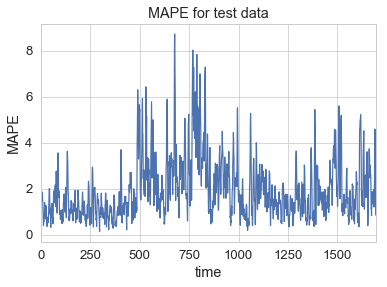

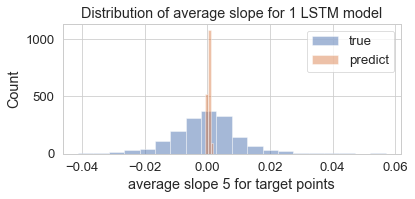

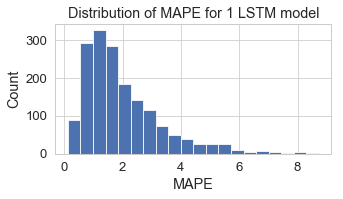

In [22]:
#use the fitted model to make predictions

#model parameters
seq_length = 25
shift = 0 
out_length = 5

x, y = sliding_windows(training_data, seq_length, shift, out_length)

if out_length > 1:
    x_ind, y_ind = sliding_windows(df.reset_index().index, seq_length, shift, out_length)
    x_true, y_true =  sliding_windows(df.y.values.reshape(-1, 1), 
                          seq_length, shift, out_length)
    y_true = y_true.reshape(-1,out_length)
    del x_ind, x_true


train_size = int(len(y) * 0.80)
test_size = len(y) - train_size

print(f'Train size is {train_size}, test size is {test_size}.')

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y).reshape(-1,out_length)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size]).reshape(-1,out_length)))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)]).reshape(-1,out_length)))

# Load the model from the file 
f_name = f'{path}/models/lstm_input{seq_length}_shift{shift}_w{window}_out{out_length}.pkl'
lstm = joblib.load(f_name)  
##predict 
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()


data_predict_log = data_predict.copy()
y_true_log = y_true.copy()

#inverse transformation
for i in range(out_length):
    data_predict[:,i] = util.inverse_transform(data_predict[:,i], m, b, ref).reshape(-1)
    dataY_plot[:,i] = util.inverse_transform(y_true[:,i], m, b, ref).reshape(-1)

mape_all = abs((data_predict - dataY_plot) / dataY_plot)* 100

print('Test MAPE:',mape_all[train_size:].mean(axis=0))


#predict for all 5 points at once:
fig = plt.figure()
mape_all = abs((data_predict - dataY_plot) / dataY_plot)* 100
#mape for the test set
df_mp = pd.DataFrame(mape_all[train_size:,:]).mean(axis=1)
df_mp.plot()
plt.ylabel('MAPE')
plt.xlabel('time')
plt.title('MAPE for test data')

#mape for test data
print('Average MAPE for test data is',mape_all[train_size:,:].mean(),
      '+/-',mape_all[train_size:,:].std())

df_y_ind = pd.DataFrame(y_ind[train_size:,:]).astype('int')
df_y_true = pd.DataFrame(y_true_log[train_size:,:])
df_y_pred = pd.DataFrame(data_predict_log[train_size:,:])


fig = plt.figure(figsize=(6,3))
df_y_true.diff(axis=1).mean(axis=1).hist(bins=20,alpha=0.5,label='true')
df_y_pred.diff(axis=1).mean(axis=1).hist(bins=3,alpha=0.5,label='predict')
plt.legend()
plt.xlabel('average slope 5 for target points')
plt.ylabel('Count')
plt.title('Distribution of average slope for 1 LSTM model')
plt.tight_layout()

#path = 'LSTM_trained_class/figs'
#fig.savefig(f'{path}/regression_slope_hist_1LSTM.png')

#for test data
fig = plt.figure(figsize=(6,3))
pd.DataFrame(mape_all[train_size:,:]).mean(axis=1).hist(bins=20,figsize=(5,3))
plt.title('Distribution of MAPE for 1 LSTM model')
plt.ylabel('Count')
_ = plt.xlabel('MAPE')
plt.tight_layout()

# path = 'LSTM_trained_class/figs'
# fig.savefig(f'{path}/regression_MAPE_hist_1LSTM.png')

In [19]:
#model for all 5 point predicted together
# fig,ax = plt.subplots(1,1,figsize=(20,4))

df_y_ind_5t = pd.DataFrame(y_ind[train_size:,:]).astype('int')
df_y_true_5t = pd.DataFrame(dataY_plot[train_size:,:])
df_y_pred_5t = pd.DataFrame(data_predict[train_size:,:])

# for i in range(30): #df_y_true.shape[0]
#     pd.DataFrame(df_y_true_5t.iloc[::5,:].T.iloc[:,i])\
#       .set_index(df_y_ind_5t.iloc[::5,:].T.iloc[:,i]).plot(marker='o',linewidth=0,ax=ax,legend=False,color='k')
#     pd.DataFrame(df_y_pred_5t.iloc[::5,:].T.iloc[:,i])\
#       .set_index(df_y_ind_5t.iloc[::5,:].T.iloc[:,i]).plot(ax=ax,legend=False,color='r')
    
# ax.set_xlabel('time')
# ax.set_ylabel('y')    
# plt.show()

Best seq_length is 25.


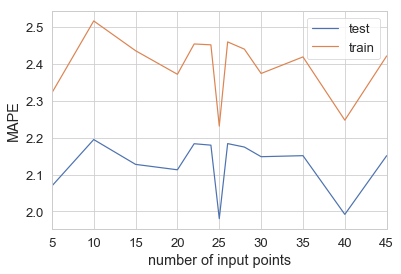

In [24]:
#for the model prediction > 1 points
df_metric_train = pd.read_csv(f'{path}/metrics_train_w{window}_out5.csv',index_col=False)
df_metric_test = pd.read_csv(f'{path}/metrics_test_w{window}_out5.csv',index_col=False)

df_metric_test.groupby('Input')['MAPE'].mean().plot(label='test')
df_metric_train.groupby('Input')['MAPE'].mean().plot(label='train')
plt.ylabel('MAPE')
plt.xlabel('number of input points')
plt.legend()
print(f'Best seq_length is 25.')

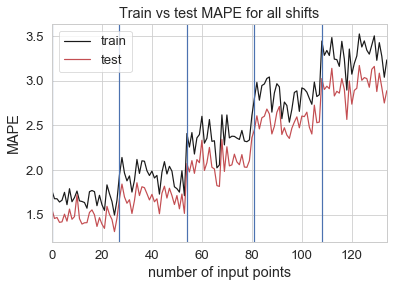

In [25]:
### for 5 models predicting 1 output
#do the plots showing input size optimization: include train and test results
#for w11 add shift =11:15
df_metric_train = pd.read_csv(f'{path}/metrics_train_w{window}_new.csv',index_col=False)
df_metric_test = pd.read_csv(f'{path}/metrics_test_w{window}_new.csv',index_col=False)

#compare metrics between train and test
df_metric_train.sort_values(by=['Shift','Input']).reset_index().MAPE.plot(color='k')
df_metric_test.sort_values(by=['Shift','Input']).reset_index().MAPE.plot(color='r')

_mul = df_metric_train.Input.max() - df_metric_train.Input.min() + 1
 
for shift in df_metric_train.Shift.unique()*_mul:
    plt.axvline(shift,0,3.6)

plt.legend(labels=['train','test'])
plt.xlabel('number of input points')
plt.ylabel('MAPE')
_ = plt.title('Train vs test MAPE for all shifts')

In [11]:
# #convert initial data to new format
# d = pd.DataFrame(columns=c)
# for i in range(5):
#     d = d.append(pd.read_csv(f'LSTM_trained/metrics_train_shift{i}.csv',index_col=False),ignore_index=True)
    
# d = d.drop('Unnamed: 0',axis=1).drop(d[d.Input==15].index,axis=0)
# d.to_csv(f'LSTM_trained/metrics_train_w{window}.csv')

In [28]:
#find optimal sequence
df_choose = pd.read_csv(f'{path}/metrics_test_w{window}.csv',index_col=False)
mape_mins = df_choose.groupby(['Shift'])['MAPE'].min()

opt_seq = []
#optimal sequences
for _shift, _mape in enumerate(mape_mins):
    opt_seq.append(int(df_choose[(df_choose.Shift == _shift)&
                             (df_choose.MAPE == _mape)]['Input']))
    #print(_shift,_mape)
    
#check parameters
target, window, opt_seq

('y_smooth_w8', 8, [29, 20, 17, 18, 14])

Average MAPE for test data is 1.9125997568488453 +/- 1.9106067561295077


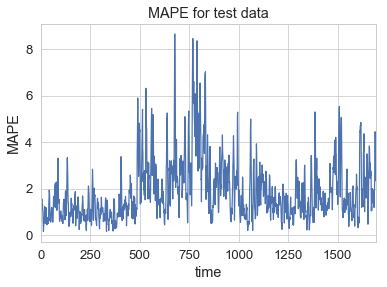

In [55]:
#models has been trained and saved
#combine N models to predict N points
#load best lstm models with shift =[0,4]

const_seq = [8,8,8,8,8]

seq_lengths = opt_seq #const_seq #opt_seq 
shifts = np.arange(5)

data_predict_5 = np.ones((len(training_data) - max(seq_lengths) - 5,5))
data_true_5 = data_predict_5.copy()

data_predict_5_log = data_predict_5.copy()
data_true_5_log = data_predict_5.copy()

data_y_ind_5 = data_predict_5.copy()

i = 0
#use actual target
#target = 'y' #'smooth_y' or 'y'
training_data = df[target].values.reshape(-1, 1)

for seq_length, shift in zip(seq_lengths, shifts):   
    
    #x, y = sliding_windows(training_data, seq_length, shift)
    #smoothed data
    x, y = sliding_windows_group(training_data, seq_length, max(seq_lengths),shift)
    
    #actual data
    x_true, y_true =  sliding_windows_group(df.y.values.reshape(-1, 1), 
                                            seq_length, max(seq_lengths),shift)
    
    #actual data
    x_ind, y_ind =  sliding_windows_group(np.arange(0,len(df)),
                                            seq_length, max(seq_lengths),shift)
    
    train_size = int(len(y) * 0.80)
    test_size = len(y) - train_size
    
    #print(f'Train size is {train_size}, test size is {test_size}.')
    
    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))
    dataY_true = Variable(torch.Tensor(np.array(y_true)))
    
    # Load the model from the file 
    f_name = f'{path}/models/lstm_input{seq_length}_shift{shift}_w{window}.pkl'
    lstm_load = joblib.load(f_name)  

    # Use the loaded model to make predictions 
    train_predict = lstm_load(dataX) 
    data_predict = train_predict.data.numpy()
    dataY_plot = dataY.data.numpy()
    dataY_true_plot = dataY_true.data.numpy()
    
    #log transformed
    data_predict_5_log[:,i] = np.squeeze(data_predict)
    data_true_5_log[:,i] = np.squeeze(dataY_true_plot)

    data_predict = util.inverse_transform(data_predict, m, b, ref, y_ind[0])
    # if smoothed target(), df.y[seq_length:] are actual values
    #dataY_plot = inverse_transform(df.y[seq_length + shift:]) 
    dataY_true_plot = util.inverse_transform(dataY_true_plot, m, b, ref, y_ind[0])
    
    #actual values (original scale)
    data_predict_5[:,i] = np.squeeze(data_predict)
    data_true_5[:,i] = np.squeeze(dataY_true_plot)
    
    data_y_ind_5[:,i] = np.squeeze(Variable(torch.Tensor(np.array(y_ind))).data.numpy())
        
    i += 1
    
mape_all = abs((data_predict_5 - data_true_5) / data_true_5)* 100
#mape for the test set
pd.DataFrame(mape_all[train_size:,:]).mean(axis=1).plot()
plt.ylabel('MAPE')
plt.xlabel('time')
plt.title('MAPE for test data')

#mape for test data
print('Average MAPE for test data is',mape_all[train_size:,:].mean(),
      '+/-',mape_all[train_size:,:].std())

#### 5 different models for 5 output points

* For constant seq_length=8 and actual target: Average MAPE for test data is Average MAPE for test data is 2.6264267406273984 +/- 2.586720762197505


* For constant seq_length=8 and smooth (w=11) target: Average MAPE for test data is 2.140336938424094 +/- 2.0698828673815686
* For optimal seq_length and smooth target (w=11): Average MAPE for test data is 2.018774750669729 +/- 1.9527099963316936


* For constant seq_length=8 and smooth (w=8) target: Average MAPE for test data is 2.190420433109745 +/- 2.1728662620722536
* For optimal seq_length and smooth (w=8) target: Average MAPE for test data is 1.9682701801476088 +/- 1.9352803501012388</font>
* For more optimal seq_length and smooth (w=8) target: Average MAPE for test data is <font color='red'>1.9125997568488453 +/- 1.9106067561295077</font>
 

* For constant seq_length=8 and smooth (w=5) target: Average MAPE for test data is 2.3025252847362276 +/- 2.2854701170817666
* For optimal seq_length and smooth(w=5) target: Average MAPE for test data is 2.1174130979902657 +/- 2.1567719639321674


* For optimal seq_length and smooth (w=8) target and hidden_size=4: Average MAPE for test data is 2.107387579564444 +/- 2.133867533036598

#### 1 model with 5 output points

* seg_length=20, out_length=5: Average MAPE for test data is 2.093041142514445 +/- 2.0798371695256597
* seg_length=25, out_length=5: Average MAPE for test data is <font color='green'>1.9806228 +/- 1.957755</font>

Average MAPE for all data is 2.0948135742619813 +/- 2.1729258432843097


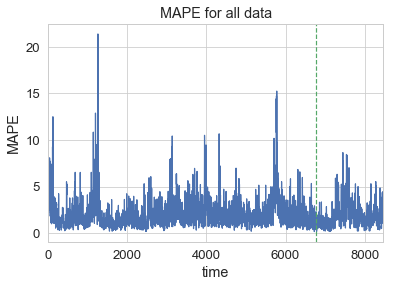

In [31]:
#mape for the train + test set
pd.DataFrame(mape_all).mean(axis=1).plot()
plt.axvline(x=train_size, c='g', linestyle='--')
plt.title('MAPE for all data')
plt.ylabel('MAPE')
plt.xlabel('time')

#mape for all data
print('Average MAPE for all data is',mape_all.mean(),
      '+/-',mape_all.std())

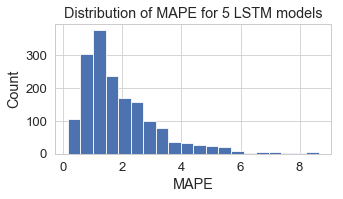

In [32]:
#for test data
fig = plt.figure(figsize=(6,3))
pd.DataFrame(mape_all[train_size:,:]).mean(axis=1).hist(bins=20,figsize=(5,3))
plt.title('Distribution of MAPE for 5 LSTM models')
plt.ylabel('Count')
_ = plt.xlabel('MAPE')
plt.tight_layout()

# path = 'LSTM_trained_class/figs'
# fig.savefig(f'{path}/regression_MAPE_hist.png')

In [33]:
df_y_ind = pd.DataFrame(data_y_ind_5[train_size:,:]).astype('int')
df_y_true = pd.DataFrame(data_true_5_log[train_size:,:])
df_y_pred = pd.DataFrame(data_predict_5_log[train_size:,:])

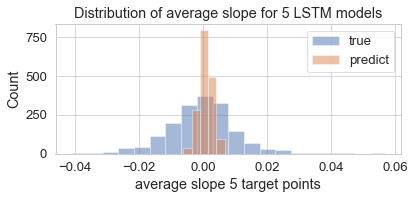

In [34]:
fig = plt.figure(figsize=(6,3))
df_y_true.diff(axis=1).mean(axis=1).hist(bins=20,alpha=0.5,label='true')
df_y_pred.diff(axis=1).mean(axis=1).hist(bins=5,alpha=0.5,label='predict')
plt.legend()
plt.xlabel('average slope 5 target points')
plt.ylabel('Count')
plt.title('Distribution of average slope for 5 LSTM models')
plt.tight_layout()

# path = 'LSTM_trained_class/figs'
# fig.savefig(f'{path}/regression_slope_hist.png')

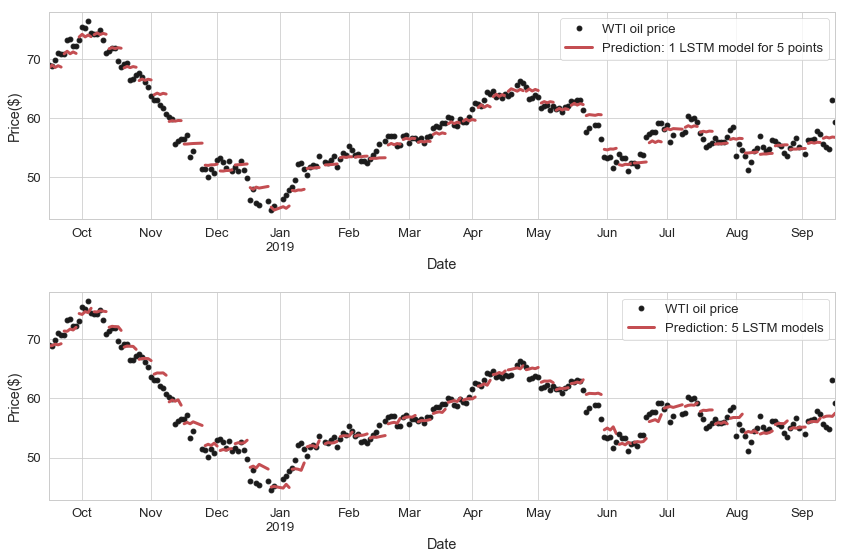

In [52]:
#for w8 with latest optimal windows 
#inverse_transform(data)
fig, (ax2,ax1) = plt.subplots(2,1,figsize=(12,8))

for i in range(239+50,339): 
    _ind = df_y_ind.iloc[::5,:].T.iloc[:,i]
    
    _data_t = util.inverse_transform(df_y_true.iloc[::5,:].T.iloc[:,i].values, m, b, ref,_ind.values[0]).reshape(-1)    
    pd.DataFrame(_data_t).set_index(df.index[_ind]).plot(marker='o',lw=0,ax=ax1,legend=False,color='k')
        
    _data = util.inverse_transform(df_y_pred.iloc[::5,:].T.iloc[:,i].values, m, b, ref,_ind.values[0]).reshape(-1)
    pd.DataFrame(_data).set_index(df.index[_ind]).plot(lw=3,ax=ax1,legend=False,color='r')
       
    #all 5 points together
    pd.DataFrame(_data_t).set_index(df.index[_ind]).plot(marker='o',lw=0,ax=ax2,legend=False,color='k')
    
    pd.DataFrame(df_y_pred_5t.iloc[::5,:].T.iloc[:,i])\
      .set_index(df.index[df_y_ind_5t.iloc[::5,:].T.iloc[:,i]])\
      .plot(ax=ax2,legend=False,color='r',lw=3)


ax1.legend(('WTI oil price','Prediction: 5 LSTM models'))
ax1.set_xlabel('Date')
ax1.set_ylabel('Price($)')

ax2.legend(('WTI oil price','Prediction: 1 LSTM model for 5 points'))
ax2.set_xlabel('Date')
ax2.set_ylabel('Price($)')

plt.tight_layout()
plt.show()

# path = 'LSTM_trained_class/figs'
# fig.savefig(f'{path}/regression_5vs1.png')